# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Import all the required modules
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from tensorflow.contrib.layers import flatten
from skimage import img_as_ubyte

---
## Step 0: Load The Data

If you want to load the already augmented training dataset and skip the data augmentation procedure that is done to make the distribution across different labels uniform, skip past the below code to 'Load the augmented data' part of step 2 and continue. 

>**Note**: The augmentation procedure operates randomly to generate a different data set everytime it is run. This might affect the model training if you run the augmentation code each time the model is trained. 

In [2]:
# Load pickled data
training_file = './data/train.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
## Basic summary of the data set

# Number of training examples
n_train = len(y_train)

# Number of validation examples
n_valid = len(y_valid)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train[1].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

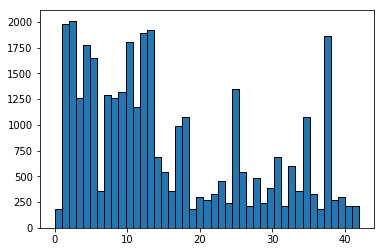

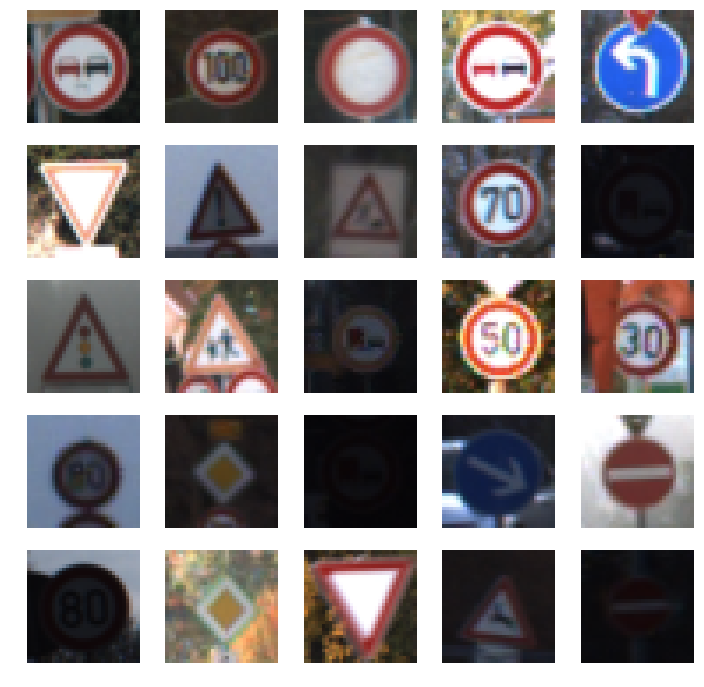

In [4]:
### Data exploration visualization code goes here.

# Visualizations will be shown in the notebook.
%matplotlib inline

# Plotting distribution of our training data
y = y_train
plt.hist(y, bins = 43, edgecolor = 'black')
plt.show()

# Let us see a few of our training images 
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))
for i in range(25):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ind_plot = np.random.randint(1, len(y_train))
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[ind_plot])
    plt.axis('off')

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Data augmentation

In [5]:
# Data transformation code to generate new images using affine transformations

# The following code was obtained from https://github.com/vxy10/ImageAugmentation

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .2+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

(32, 32, 3)


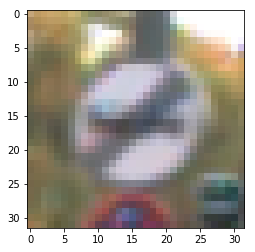

(32, 32, 3)


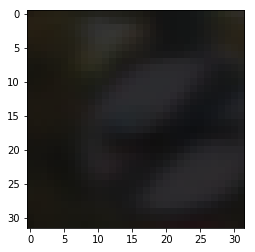

In [6]:
# Example image showing the random transformation

image = (X_train[100])
print(image.shape)
plt.imshow(image)
plt.show()

img = transform_image(image,20,10,5,brightness=1)
print(img.shape)
plt.imshow(img)


In [7]:
# Functions to augment the original dataset using transformed images to 
# get a uniform distribution across labels and also add some variations using 
# the transform_image function that can make the model more robust to variations in images

def count_requirement(X_train, y_train):
    counts = {}
    for label in set(y_train):
        # Let us aim for a minimum of 2000 images in each label class
        n_images_needed = 2000 - list(y_train).count(label)
        if n_images_needed > 0:
            counts[label] = n_images_needed
        else:
            counts[label] = 0    
    return(counts)

def create_data(X_train, y_train):
    X_new = []
    y_new = []
    counts = count_requirement(X_train, y_train)
    for i, image in enumerate(X_train):
        label = y_train[i]
        if counts[label] != 0:
            y_new.append(label)
            X_new.append(transform_image(image,20,10,5,brightness=1))
            counts[label] -= 1
    if X_new != []:
        X_train = np.concatenate((X_train, X_new), axis = 0)
        y_train = np.concatenate((y_train, y_new), axis = 0)
    return X_train, y_train, counts

In [8]:
# Repeating the data creation using the create_data function untill we 
# have atleast 2000 images in each class

counts = count_requirement(X_train, y_train)
while (sum(counts.values()) != 0):
    X_train, y_train, counts = create_data(X_train, y_train)

New number of training examples = 86010


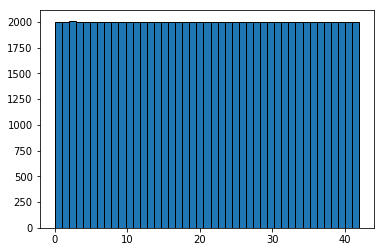

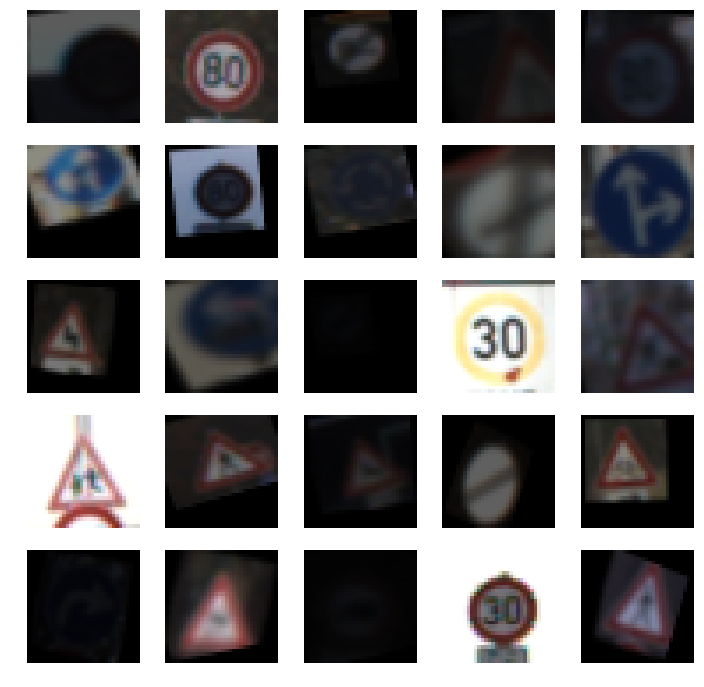

In [9]:

# New number of training examples
n_train = len(y_train)

print("New number of training examples =", n_train)

# Plotting new distribution of our training data
y = y_train

plt.hist(y, bins = 43, edgecolor = 'black')
plt.show()

# Let us see a few of our training images 
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))
for i in range(25):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ind_plot = np.random.randint(1, len(y_train))
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[ind_plot])
    plt.axis('off')

plt.show()

In [10]:
# Saving the new augmented training data

train_aug = {'features': X_train, 'labels': y_train}
pickle.dump(train_aug, open('data/train_aug.p', 'wb'))

### Load the augmented data

In [11]:
# If you're directly loading the already augmented training data, 
# just run this and continue (make sure to import all the required 
# modules at the beginning of the notebook first.)

training_file = './data/train_aug.p'
validation_file= './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [12]:
# Shuffle
X_train, y_train = shuffle(X_train, y_train)

### Pre-process the Data Set 

In [13]:

# RGB to GRAY
def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Normalizing the scale to [-1, 1]
def normalize(img):
    return (img/127.5 - 1.0)

def preprocess(x):
    processed_data = []
    for i in range(0, x.shape[0]):
        img = rgb2gray(x[i])
        img = cv2.equalizeHist(img)
        img = normalize(img)
        processed_data.append(img)
    return np.reshape(np.array(processed_data), (-1, 32, 32, 1))


In [14]:
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)

print(X_train.shape, X_train.dtype)
print(X_valid.shape, X_valid.dtype)

(86010, 32, 32, 1) float64
(4410, 32, 32, 1) float64


### Model Architecture

In [15]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 25
BATCH_SIZE = 128

In [16]:
# Model architecture
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID', name = 'conv1') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID', name = 'conv2') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [18]:
rate = 0.0022

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, k_prob):
    num_examples = len(X_data)
    total_loss, total_accuracy = 0, 0    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: k_prob})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH 1 ...
Training loss = 1.123
Training accuracy = 0.674
Validation loss = 0.443
Validation accuracy = 0.864

EPOCH 2 ...
Training loss = 0.784
Training accuracy = 0.770
Validation loss = 0.257
Validation accuracy = 0.920

EPOCH 3 ...
Training loss = 0.639
Training accuracy = 0.812
Validation loss = 0.197
Validation accuracy = 0.937

EPOCH 4 ...
Training loss = 0.541
Training accuracy = 0.839
Validation loss = 0.178
Validation accuracy = 0.940

EPOCH 5 ...
Training loss = 0.486
Training accuracy = 0.856
Validation loss = 0.181
Validation accuracy = 0.942

EPOCH 6 ...
Training loss = 0.437
Training accuracy = 0.868
Validation loss = 0.153
Validation accuracy = 0.950

EPOCH 7 ...
Training loss = 0.422
Training accuracy = 0.873
Validation loss = 0.166
Validation accuracy = 0.948

EPOCH 8 ...
Training loss = 0.396
Training accuracy = 0.881
Validation loss = 0.171
Validation accuracy = 0.946

EPOCH 9 ...
Training loss = 0.370
Training accuracy = 0.890
Validation loss = 0.149

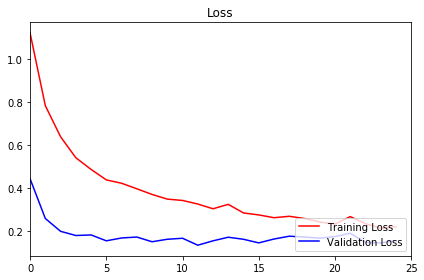

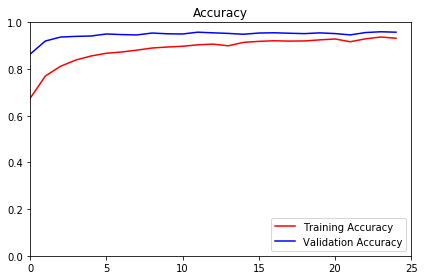

Model saved


In [20]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    training_loss_history = []
    validation_loss_history = []
    training_accuracy_history = []
    validation_accuracy_history = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})
        
        # Log accuracy and loss every epoch
        training_loss, training_accuracy = evaluate(X_train,y_train, 1.0)
        training_loss_history.append(training_loss)
        training_accuracy_history.append(training_accuracy)

        val_loss, val_acc = evaluate(X_valid, y_valid, 1.0)
        validation_loss_history.append(val_loss)
        validation_accuracy_history.append(val_acc)

        print("EPOCH {} ...".format(i+1))
        print("Training loss = {:.3f}".format(training_loss))
        print("Training accuracy = {:.3f}".format(training_accuracy))
        print("Validation loss = {:.3f}".format(val_loss))
        print("Validation accuracy = {:.3f}".format(val_acc))
        print()
    
    #loss_plot = plt.subplot(2,1,1)
    loss_plot = plt.subplot()
    loss_plot.set_title('Loss')
    loss_plot.plot(training_loss_history, 'r', label='Training Loss')
    loss_plot.plot(validation_loss_history, 'b', label='Validation Loss')
    loss_plot.set_xlim([0, EPOCHS])
    loss_plot.legend(loc=4)
    plt.tight_layout()
    plt.savefig('loss.png')
    plt.show()
    
    #acc_plot = plt.subplot(2,1,2)
    acc_plot = plt.subplot()
    acc_plot.set_title('Accuracy')
    acc_plot.plot(training_accuracy_history,'r', label='Training Accuracy')
    acc_plot.plot(validation_accuracy_history, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([0, EPOCHS])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.savefig('accuracy.png')
    plt.show()
        
    saver.save(sess, './lenet')
    print("Model saved")

#### Evaluating the performance of our model on the testing set

In [21]:
# Preprocess
X_test = preprocess(X_test)

In [22]:
print(X_test.shape)

(12630, 32, 32, 1)


In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_loss, test_accuracy = evaluate(X_test, y_test, 1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.926


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

(32, 32, 3)
uint8


/home/kh/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


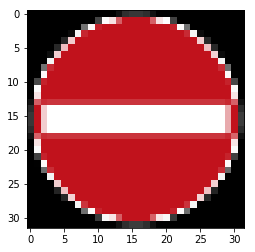

(32, 32, 3)
uint8


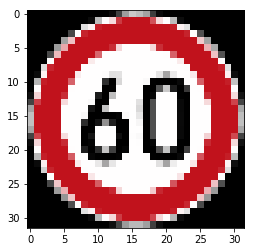

(32, 32, 3)
uint8


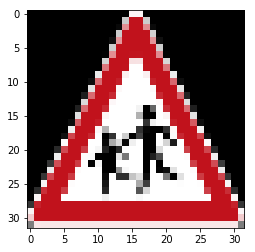

(32, 32, 3)
uint8


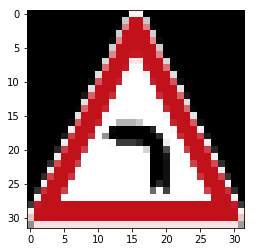

(32, 32, 3)
uint8


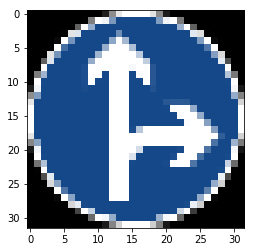

(32, 32, 3)
uint8


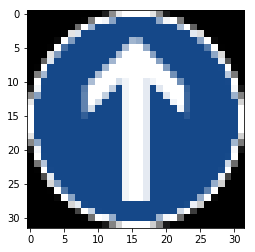

(32, 32, 3)
uint8


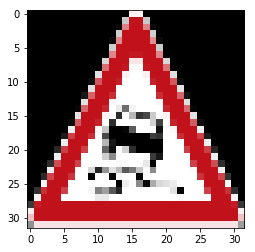

In [24]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

custom_X_test = []
for image_name in ['no_entry', 'limit_sixty', 'children_crossing', 'dangerous_curve_to_the_left', 'go_straight_or_right',\
                  'ahead_only', 'slippery_road']:
    img = mpimg.imread("./test_images/%s.png" %image_name)
    img = img_as_ubyte(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, (32, 32))
    custom_X_test.append(img)

custom_X_test = np.array(custom_X_test)

for i in custom_X_test:
    print(i.shape)
    print(i.dtype)
    plt.imshow(i)
    plt.show()
    

### Predict the Sign Type for Each Image

In [25]:
# Preprocessing test images to the required format
custom_X_test = preprocess(custom_X_test)

In [26]:
custom_X_test = custom_X_test.astype(np.float32)
print(custom_X_test.shape, custom_X_test.dtype) 

(7, 32, 32, 1) float32


In [28]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

softmax = tf.nn.softmax(logits)
top_predictions = tf.nn.top_k(softmax, 5)

def softmax_probs(X_data):
    sess = tf.get_default_session()
    softmax = sess.run(top_predictions, feed_dict = {x: X_data, keep_prob: 1.0})
    return softmax

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_prob5 = softmax_probs(custom_X_test)
    print('Probabilities: \n', softmax_prob5.values)
    print('Predicted Classes: \n', softmax_prob5.indices)

Probabilities: 
 [[  9.99972224e-01   1.04228011e-05   8.62423258e-06   4.68527105e-06
    2.27964347e-06]
 [  7.54487991e-01   1.57819837e-01   8.59578773e-02   1.32569519e-03
    2.42674127e-04]
 [  5.03532350e-01   1.52627468e-01   1.27860337e-01   1.03817753e-01
    3.92457023e-02]
 [  9.99624491e-01   3.74983385e-04   2.49027721e-07   9.89411930e-08
    6.93348809e-08]
 [  9.53878284e-01   4.55646999e-02   4.92580235e-04   4.01642319e-05
    1.00820680e-05]
 [  9.99984860e-01   1.09237735e-05   3.38223981e-06   5.78736262e-07
    2.01153043e-07]
 [  9.45111454e-01   5.46907373e-02   7.82437564e-05   4.31267326e-05
    3.43544598e-05]]
Predicted Classes: 
 [[17 40 42 16 12]
 [40  3 16  0  9]
 [23 19 20 18 22]
 [19 23 22 20  9]
 [36 11 35 40 42]
 [35 37 34 11 25]
 [23 21 11 31 22]]


So the predictions for our images from the web are as follows:
    
    Image 1 (Sign: no_entry, ClassId: 17) - Predicted as ClassId 17 (no entry)
    Image 2 (Sign: speed_limit_60, ClassId: 3) - Predicted as ClassId 40 (roundabout mandatory)
    Image 3 (Sign: children_crossing, ClassId: 28) - Predicted as ClassId 23 (slippery road)
    Image 4 (Sign: dangerous_curve_to_the_left , ClassId: 19) - Predicted as ClassId 19 (dangerous curve to the left)
    Image 5 (Sign: go_straight_or_right, ClassId: 36) - Predicted as ClassId 36 (go straight or right)
    Image 6 (Sign: ahead_only , ClassId: 35) - Predicted as ClassId 35 (ahead only)
    Image 7 (Sign: slippery_road, ClassId: 23) - Predicted as ClassId 23 (slippery road)
    

### Analyze Performance

In [29]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

n_correct_predictions = 5.0
n_total_predictions = 7.0
accuracy = 100 * n_correct_predictions / n_total_predictions

print('Accuracy on new images from the web:', accuracy, '%')

Accuracy on new images from the web: 71.42857142857143 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [30]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_prob5 = softmax_probs(custom_X_test)
    print('Probabilities: \n', softmax_prob5.values)
    print('Predicted Classes: \n', softmax_prob5.indices)

Probabilities: 
 [[  9.99972224e-01   1.04228011e-05   8.62423258e-06   4.68527105e-06
    2.27964347e-06]
 [  7.54487991e-01   1.57819837e-01   8.59578773e-02   1.32569519e-03
    2.42674127e-04]
 [  5.03532350e-01   1.52627468e-01   1.27860337e-01   1.03817753e-01
    3.92457023e-02]
 [  9.99624491e-01   3.74983385e-04   2.49027721e-07   9.89411930e-08
    6.93348809e-08]
 [  9.53878284e-01   4.55646999e-02   4.92580235e-04   4.01642319e-05
    1.00820680e-05]
 [  9.99984860e-01   1.09237735e-05   3.38223981e-06   5.78736262e-07
    2.01153043e-07]
 [  9.45111454e-01   5.46907373e-02   7.82437564e-05   4.31267326e-05
    3.43544598e-05]]
Predicted Classes: 
 [[17 40 42 16 12]
 [40  3 16  0  9]
 [23 19 20 18 22]
 [19 23 22 20  9]
 [36 11 35 40 42]
 [35 37 34 11 25]
 [23 21 11 31 22]]


---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excercise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [46]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    sess = tf.get_default_session()
    logits = LeNet(x)
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

/home/kh/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


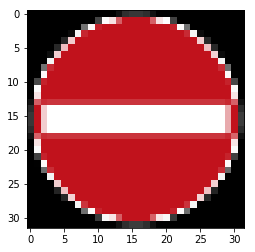

(1, 32, 32, 1) float32


In [63]:
img = mpimg.imread("./test_images/no_entry.png")
img = img_as_ubyte(img)
img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
img = cv2.resize(img, (32, 32))
plt.imshow(img)
plt.show()
img = np.array([img])
img = preprocess(img).astype(np.float32)
print(img.shape, img.dtype)

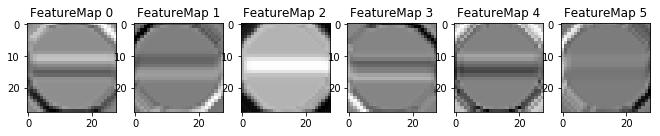

In [64]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_1_visual = sess.graph.get_tensor_by_name('conv1:0')
    outputFeatureMap(img,conv_layer_1_visual)

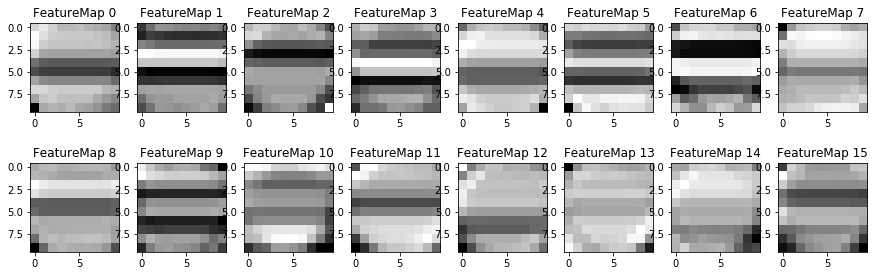

In [65]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv_layer_2_visual = sess.graph.get_tensor_by_name('conv2:0')
    outputFeatureMap(img,conv_layer_2_visual)

The above visualizations show the activations of our 2 convolutional layers in the network when passed with a no_entry road sign. First layer activations show that the basic patterns like different contrasts are learned. The second layer activations show us that more complex patterns that are different combinations of the previously learned patterns are learned.  